In [138]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from ggplot import *
%matplotlib inline

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD

import re, nltk, spacy, gensim
from nltk.corpus import stopwords

# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [84]:
car_review = pd.read_csv('car_review.csv', index_col=0)

In [85]:
car_review.head()

,Rating,Year,Review,Brand
1,4,\n by JayeMaye\n ...,\n This is what I've bought Sat...,dodge-charger-2012/consumer-reviews/
2,5,\n by Female Driver\n ...,\n I just got my Special Order ...,dodge-charger-2012/consumer-reviews/
3,5,\n by New Car Buyer\n ...,\n About 2 months ago I purchas...,dodge-charger-2012/consumer-reviews/
4,5,\n by KTisaPhillyPhan\n ...,\n We bought a tungsten metalli...,dodge-charger-2012/consumer-reviews/
5,5,\n by I<3DODGE\n ...,\n I have a 2012 Dodge Charger ...,dodge-charger-2012/consumer-reviews/


In [86]:
car_review.Rating.value_counts()

5    14704
4     3211
3      730
2      313
1      284
Name: Rating, dtype: int64

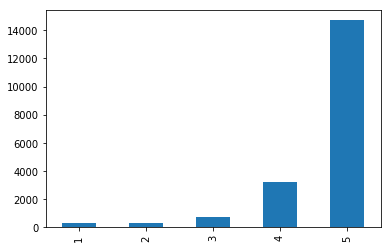

In [87]:
car_review.Rating.value_counts(sort=False).plot(kind = 'bar')
plt.show()

* Reviews are skewed towards positive

# Cleaning data and retrive features

### Car

In [88]:
car_review['Car'] = car_review.Brand.map(lambda x: x.split('/')[0])
car_review['Car_Year'] = car_review['Car'].map(lambda x: x.split('-')[-1])
car_review['Car_test'] = car_review['Car'].map(lambda x: x.split('-')[:-1])
car_review['Car_Make'] = car_review['Car_test'].map(lambda x: x[0])
car_review['Car_Model'] = car_review['Car_test'].map(lambda x: x[-1])

In [89]:
car_review.drop(['Car_test'], axis=1, inplace=True)

In [90]:
car_review.head()

,Rating,Year,Review,Brand,Car,Car_Year,Car_Make,Car_Model
1,4,\n by JayeMaye\n ...,\n This is what I've bought Sat...,dodge-charger-2012/consumer-reviews/,dodge-charger-2012,2012,dodge,charger
2,5,\n by Female Driver\n ...,\n I just got my Special Order ...,dodge-charger-2012/consumer-reviews/,dodge-charger-2012,2012,dodge,charger
3,5,\n by New Car Buyer\n ...,\n About 2 months ago I purchas...,dodge-charger-2012/consumer-reviews/,dodge-charger-2012,2012,dodge,charger
4,5,\n by KTisaPhillyPhan\n ...,\n We bought a tungsten metalli...,dodge-charger-2012/consumer-reviews/,dodge-charger-2012,2012,dodge,charger
5,5,\n by I<3DODGE\n ...,\n I have a 2012 Dodge Charger ...,dodge-charger-2012/consumer-reviews/,dodge-charger-2012,2012,dodge,charger


### Reviews

In [91]:
car_review['Review'] = car_review['Review'].map(lambda x: x.rstrip().lstrip())

In [92]:
car_review['Review'].head()

1    This is what I've bought Saturday:\n2012 Dodge...
2    I just got my Special Order wiith my name on w...
3    About 2 months ago I purchased a new Dodge Cha...
4    We bought a tungsten metallic SXT-Plus Charger...
5    I have a 2012 Dodge Charger R/T Plus AWD in re...
Name: Review, dtype: object

### Remove duplicate review
* There are some duplicate reviews in the dataset

In [93]:
car_review.shape

(19242, 8)

In [94]:
car_review.Review.nunique()

10821

In [95]:
car_review.Review.value_counts().head(5)

A solid compact sedan. I owned a Civic years ago, and I like the emergency brake redesign. The gas cap is gone, and the lid over the gas fill intake locks when the doors lock, and unlocks when the doors unlock. This makes a lot of sense.    52
I am very happy with my purchase. No buyers remorse at all. Fast, fun, reliable and comfortable! Would highly recommend this car to anyone. You will not find more bang for you buck.                                                            52
Excellent car. Excellent performance and very stylish. Handles excellent on the road. When you need the power this car has it with no problem.                                                                                                   50
This is my first new car and I am happy with the comfort and look of the car.  The Civic Hatchback is great to handle and the technical aspects of the car are easy to understand.                                                               50
This car is great for yo

In [96]:
car_review=car_review.drop_duplicates(subset=['Review'])

In [97]:
print('Number of unique reviews: ', car_review.Review.nunique())
print('Shape of the dataset: ', car_review.shape)

Number of unique reviews:  10821
Shape of the dataset:  (10821, 8)


In [98]:
car_review.head()

,Rating,Year,Review,Brand,Car,Car_Year,Car_Make,Car_Model
1,4,\n by JayeMaye\n ...,This is what I've bought Saturday:\n2012 Dodge...,dodge-charger-2012/consumer-reviews/,dodge-charger-2012,2012,dodge,charger
2,5,\n by Female Driver\n ...,I just got my Special Order wiith my name on w...,dodge-charger-2012/consumer-reviews/,dodge-charger-2012,2012,dodge,charger
3,5,\n by New Car Buyer\n ...,About 2 months ago I purchased a new Dodge Cha...,dodge-charger-2012/consumer-reviews/,dodge-charger-2012,2012,dodge,charger
4,5,\n by KTisaPhillyPhan\n ...,We bought a tungsten metallic SXT-Plus Charger...,dodge-charger-2012/consumer-reviews/,dodge-charger-2012,2012,dodge,charger
5,5,\n by I<3DODGE\n ...,I have a 2012 Dodge Charger R/T Plus AWD in re...,dodge-charger-2012/consumer-reviews/,dodge-charger-2012,2012,dodge,charger


In [99]:
car_review.Rating.value_counts()

5    7815
4    1943
3     538
2     273
1     252
Name: Rating, dtype: int64

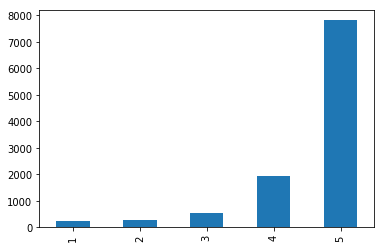

In [100]:
car_review.Rating.value_counts(sort=False).plot(kind = 'bar')
plt.show()

In [101]:
pd.crosstab(index=car_review.Rating, columns="count")/pd.crosstab(index=car_review.Rating, columns="count").sum()

col_0,count
Rating,
1,0.023288
2,0.025229
3,0.049718
4,0.179558
5,0.722207


### Create positive & negative tag 

In [102]:
car_review['tag'] = car_review['Rating'].map(lambda x:0 if x==5 else 1)

In [103]:
car_review['tag'].value_counts(sort=False)

0    7815
1    3006
Name: tag, dtype: int64

* I tag the reviews that the users not fully satisfied with the car.
#### 1: negative;
#### 0: positive.

# Topic Modeling

## 1. Removing new line characters and distracting single quotes

In [23]:
# Remove new line characters
data = [re.sub('\s+', ' ', i) for i in car_review.Review]
# Remove distracting single quotes
data = [re.sub("\'", "", i) for i in data]

## 2. Tokenize and Clean-up using gensim’s simple_preprocess()

In [25]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

In [26]:
data_words = list(sent_to_words(data))

# print(data_words[:1])

## 3. Lemmatization
* Lemmatization is a process where we convert words to its root word.
* For example: ‘Studying’ becomes ‘Study’, ‘Meeting becomes ‘Meet’, ‘Better’ and ‘Best’ becomes ‘Good’.
* The advantage of this is, we get to reduce the total number of unique words in the dictionary. As a result, the number of columns in the document-word matrix will be denser with lesser columns.

You can expect better topics to be generated in the end.

In [27]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

In [183]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# Run in terminal: python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only Noun, Adj, Verb, Adverb
data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB'])

print(data_lemmatized[:1])

['be what have buy saturday dodge charger blackberry pearl raylle package navigation system backup camera spoiler sunroof cloth seat  review trade  dodge charger leather do think would like cloth seat be okay everything inside  car be black ceiling would be able see stain major car drive love weight steering wheel  quiet inside road visibility be good find thinking excuse drive have discover sport mode which make thrilling drive make charger feel sound tiny little sport car love push button start do need take key  pocket problem will come summer time will have jacket put  key be guy have buy belt clip clip remote start be such great feature car have get use cloth seat feel good leather be think leather give cloth seat try may want purchase only thing see be problem be find comfy driving position do have power adjustable pedal one  charger guess will find time give shot have old charger would recommend trade one be build good  opinion']


## 4. Create the Document-Word matrix

In [184]:
stop_words = stopwords.words('english')
stop_words.extend(['vehicle', 'car', 'good', 'love', 'great'])

* Count Vectorizer

In [185]:
vectorizer = CountVectorizer(analyzer='word',  
                             max_df=0.95,
                             min_df=5,                        # minimum reqd occurences of a word 
                             stop_words=stop_words,             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )

data_vectorized = vectorizer.fit_transform(data_lemmatized)

In [186]:
data_vectorized.todense().shape

(10821, 3306)

* TF-IDF Vectorizer

In [187]:
tfidf_vectorizer = TfidfVectorizer(analyzer='word',       
                             max_df=0.95,
                            min_df=5,                        # minimum reqd occurences of a word 
                             stop_words=stop_words,             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )

tfidf_data_vectorized = tfidf_vectorizer.fit_transform(data_lemmatized)

In [188]:
tfidf_data_vectorized.todense().shape

(10821, 3306)

## 5. Check the Sparsicity

* Sparsicity is nothing but the percentage of non-zero datapoints in the document-word matrix, that is data_vectorized.
* Since most cells in this matrix will be zero, I am interested in knowing what percentage of cells contain non-zero values.

* Count Vectorizer

In [189]:
# Materialize the sparse data
data_dense = data_vectorized.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Count Vectorizer Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Count Vectorizer Sparsicity:  0.7285524500236568 %


* TF-IDF Vectorizer

In [190]:
# Materialize the sparse data
tfidf_data_dense = tfidf_data_vectorized.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Count Vectorizer Sparsicity: ", ((tfidf_data_dense > 0).sum()/tfidf_data_dense.size)*100, "%")

Count Vectorizer Sparsicity:  0.7285524500236568 %


## 6. Build LDA model with sklearn
* Everything is ready to build a Latent Dirichlet Allocation (LDA) model. Let’s initialise one and call fit_transform() to build the LDA model.

* Count Vectorizer

In [191]:
# Build LDA Model
lda_model = LatentDirichletAllocation(n_topics=20,               # Number of topics
                                      max_iter=10,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(data_vectorized)

print(lda_model)  # Model attributes

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=-1, n_topics=20, perp_tol=0.1,
             random_state=100, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)


* TF-IDF Vectorizer

In [192]:
# Build LDA Model
tfidf_lda_model = LatentDirichletAllocation(n_topics=20,               # Number of topics
                                      max_iter=10,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )
tfidf_lda_output = tfidf_lda_model.fit_transform(tfidf_data_vectorized)

print(tfidf_lda_model)  # Model attributes

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=-1, n_topics=20, perp_tol=0.1,
             random_state=100, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)


## 7. Diagnose model performance with perplexity and log-likelihood
* A model with higher log-likelihood and lower perplexity (exp(-1. * log-likelihood per word)) is considered to be good. Let’s check for our model.

* Count Vectorizer

In [193]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))

# See model parameters
print(lda_model.get_params())

Log Likelihood:  -2110112.0865062396
Perplexity:  1078.9567319603343
{'batch_size': 128, 'doc_topic_prior': None, 'evaluate_every': -1, 'learning_decay': 0.7, 'learning_method': 'online', 'learning_offset': 10.0, 'max_doc_update_iter': 100, 'max_iter': 10, 'mean_change_tol': 0.001, 'n_components': 10, 'n_jobs': -1, 'n_topics': 20, 'perp_tol': 0.1, 'random_state': 100, 'topic_word_prior': None, 'total_samples': 1000000.0, 'verbose': 0}


* TF-IDF Vectorizer

In [194]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", tfidf_lda_model.score(tfidf_data_vectorized))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", tfidf_lda_model.perplexity(tfidf_data_vectorized))

# See model parameters
print(tfidf_lda_model.get_params())

Log Likelihood:  -381940.5127009185
Perplexity:  4280.170262239667
{'batch_size': 128, 'doc_topic_prior': None, 'evaluate_every': -1, 'learning_decay': 0.7, 'learning_method': 'online', 'learning_offset': 10.0, 'max_doc_update_iter': 100, 'max_iter': 10, 'mean_change_tol': 0.001, 'n_components': 10, 'n_jobs': -1, 'n_topics': 20, 'perp_tol': 0.1, 'random_state': 100, 'topic_word_prior': None, 'total_samples': 1000000.0, 'verbose': 0}


Therefore, I choose Count Vectorizer preprocessing method.

## 8. GridSearch the best LDA model
* The most important tuning parameter for LDA models is n_components (number of topics). In addition, I am going to search learning_decay (which controls the learning rate) as well.
* Besides these, other possible search params could be learning_offset (downweigh early iterations. Should be > 1) and max_iter. These could be worth experimenting if you have enough computing resources.

In [195]:
# Define Search Param
search_params = {'n_components': [8, 10, 12, 15], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)

GridSearchCV(cv=None, error_score='raise',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_components=10, n_jobs=1,
             n_topics=None, perp_tol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_components': [8, 10, 12, 15], 'learning_decay': [0.5, 0.7, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

## 9. The best topic model and its parameters

In [196]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': 0.7, 'n_components': 8}
Best Log Likelihood Score:  -720237.7608157202
Model Perplexity:  938.3049077316027


## Crate model with best parameters

In [197]:
best_lda_model = LatentDirichletAllocation(learning_decay=0.7, n_components=8)
best_lda_output = best_lda_model.fit_transform(data_vectorized)

In [198]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", best_lda_model.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", best_lda_model.perplexity(data_vectorized))

Log Likelihood:  -2064280.0183206934
Perplexity:  927.0999512069643


## 10. The dominant topic in each document

* To classify a document as belonging to a particular topic, a logical approach is to see which topic has the highest contribution to that document and assign it.
* In the table below, I’ve greened out all major topics in a document and assigned the most dominant topic in its own column.

In [199]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [200]:
print("\nTopics in LDA model:")
tf_feature_names = vectorizer.get_feature_names()
print_top_words(best_lda_model, tf_feature_names, 12)


Topics in LDA model:
Topic #0: class performance sedan malibu comfort fact perfect fit top engine chevrolet chrysler
Topic #1: drive comfortable gas look mileage ride get interior smooth feature room nice
Topic #2: honda mazda accord drive camry new civic model buy toyota look corolla
Topic #3: mpg get highway mile gas transmission mileage fuel speed city sonata average
Topic #4: work service dealership experience whistle bell help deal salesman clean make take
Topic #5: would recommend value purchase look price new buy happy turbo ford reliable
Topic #6: get buy drive new year mile would problem time take nissan say
Topic #7: seat wheel system control steering use driver feel rear light make front



In [201]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(data_vectorized)

In [202]:
# column names
topicnames = []
for topic_idx, topic in enumerate(best_lda_model.components_):
    topicnames.append("Topic #%d: " % topic_idx)

In [203]:
# index names
docnames = ["Doc" + str(i) for i in range(len(data))]

In [204]:
# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

In [205]:
# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic
df_document_topic.head()

,Topic #0:,Topic #1:,Topic #2:,Topic #3:,Topic #4:,Topic #5:,Topic #6:,Topic #7:,dominant_topic
Doc0,0.00,0.00,0.00,0.00,0.0,0.15,0.15,0.69,7
Doc1,0.04,0.40,0.17,0.00,0.0,0.00,0.00,0.39,1
Doc2,0.00,0.20,0.00,0.56,0.0,0.22,0.00,0.00,3
Doc3,0.00,0.59,0.00,0.10,0.0,0.28,0.00,0.00,1
Doc4,0.00,0.83,0.00,0.00,0.0,0.08,0.00,0.07,1


## 11. Review topics distribution across documents

In [206]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
topic_contribution = round(df_topic_distribution['Num Documents']/df_topic_distribution['Num Documents'].sum(), 4)# Percentage of Documents for Each Topic
df_topic_distribution['Perc_Documents'] = topic_contribution
df_topic_distribution

,Topic Num,Num Documents,Perc_Documents
0,1,4267,0.3943
1,6,2086,0.1928
2,7,1507,0.1393
3,2,1057,0.0977
4,5,891,0.0823
5,3,632,0.0584
6,4,258,0.0238
7,0,123,0.0114


## 12. Visualize the LDA model with pyLDAvis
* The pyLDAvis offers the best visualization to view the topics-keywords distribution.
* A good topic model will have fairly big, non-overlapping bubbles scattered throughout the chart instead of being clustered in one quadrant.

（A model with too many topics, will typically have many overlaps, small sized bubbles clustered in one region of the chart.）

（If you move the cursor over one of the bubbles, the words and bars on the right-hand side will update. These words are the salient keywords that form the selected topic.）

In [207]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, data_vectorized, vectorizer, mds='tsne')
panel

PreparedData(topic_coordinates=            Freq  cluster  topics           x           y
topic                                                    
1      22.583543        1       1   43.549732 -109.662727
7      19.640747        1       2  -45.022690 -129.180649
6      19.571092        1       3   44.770401   53.765392
2      11.188142        1       4  -43.499825   74.608315
3      10.132489        1       5  -21.004629  -27.461145
5       7.501361        1       6   83.509399  -28.242489
4       4.998169        1       7 -114.829552   18.589584
0       4.384457        1       8 -115.509888  -72.105400, topic_info=     Category         Freq          Term        Total  loglift  logprob
term                                                                   
1880  Default  1791.000000           mpg  1791.000000  30.0000  30.0000
1365  Default  1277.000000         honda  1277.000000  29.0000  29.0000
1198  Default  2782.000000           gas  2782.000000  28.0000  28.0000
3280  Default  2610.000000         would  2610.000000  27.0000  27.0000
2334  Default  1118.000000     recommend  1118.000000  26.0000  26.0000
2535  Default  2588.000000          seat  2588.000000  25.0000  25.0000
1778  Default  1105.000000         mazda  1105.000000  24.0000  24.0000
1821  Default  2029.000000          mile  2029.000000  23.0000  23.0000
1350  Default   971.000000       highway   971.000000  22.0000  22.0000
21    Default   889.000000        accord   889.000000  21.0000  21.0000
3149  Default   779.000000         value   779.000000  20.0000  20.0000
1822  Default  2003.000000       mileage  2003.000000  19.0000  19.0000
1929  Default  2661.000000           new  2661.000000  18.0000  18.0000
2246  Default  1754.000000      purchase  1754.000000  17.0000  17.0000
1216  Default  4908.000000           get  4908.000000  16.0000  16.0000
1694  Default  3246.000000          look  3246.000000  15.0000  15.0000
530   Default  2371.000000   comfortable  2371.000000  14.0000  14.0000
373   Default  2879.000000           buy  2879.000000  13.0000  13.0000
2457  Default  1035.000000          room  1035.000000  12.0000  12.0000
395   Default   847.000000         camry   847.000000  11.0000  11.0000
2207  Default  1314.000000         price  1314.000000  10.0000  10.0000
482   Default   625.000000         civic   625.000000   9.0000   9.0000
2687  Default  1238.000000        smooth  1238.000000   8.0000   8.0000
3035  Default   785.000000  transmission   785.000000   7.0000   7.0000
529   Default   806.000000       comfort   806.000000   6.0000   6.0000
2098  Default   949.000000   performance   949.000000   5.0000   5.0000
2369  Default  1094.000000      reliable  1094.000000   4.0000   4.0000
1172  Default   796.000000          fuel   796.000000   3.0000   3.0000
873   Default  6053.000000         drive  6053.000000   2.0000   2.0000
2737  Default   806.000000         speed   806.000000   1.0000   1.0000
...       ...          ...           ...          ...      ...      ...
2485   Topic8    35.856623          rust    36.729406   3.1031  -5.9120
3161   Topic8    34.575652          vent    35.448825   3.1022  -5.9484
670    Topic8    34.060550      creature    34.934170   3.1018  -5.9634
486    Topic8    32.830650       classic    33.703015   3.1009  -6.0002
475    Topic8   136.141427      chrysler   161.519387   2.9562  -4.5779
2730   Topic8    77.131421         speak    87.752408   2.9981  -5.1461
485    Topic8   260.733599         class   400.246434   2.6985  -3.9281
1738   Topic8   228.039048        malibu   344.651291   2.7141  -4.0620
363    Topic8    76.139471        bumper    93.967543   2.9167  -5.1590
2373   Topic8    52.184780        remain    58.648315   3.0103  -5.5368
1813   Topic8   133.649047           mid   201.470025   2.7167  -4.5963
1101   Topic8    98.005152        finish   141.374217   2.7607  -4.9065
2046   Topic8    94.403603         paint   144.942618   2.6983  -4.9440
1648   Topic8   111.437512         level   189.175148   2.5979  -

## 13. See the Topic’s keywords

In [208]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames

# View
df_topic_keywords.head()

,ability,able,abnormal,abs,absolute,absorb,abundance,abundant,accelerate,acceleration,...,yield,yokohama,york,young,youtube,yrs,zip,zippy,zone,zoom
Topic #0:,0.125348,0.125298,0.125262,0.125192,0.125477,0.125063,0.125538,0.125236,25.992058,0.125232,...,0.125307,6.252596,0.125166,0.125207,0.125132,0.125212,5.871094,0.125234,0.125127,0.125309
Topic #1:,39.123593,52.863406,0.125029,0.125097,0.125256,0.125198,0.125589,0.125132,0.125210,183.863844,...,0.132470,0.125054,16.742632,50.496579,1.410994,0.125154,0.125509,0.125198,0.125140,0.125400
Topic #2:,8.915292,8.664772,0.125151,0.125134,0.125295,12.782230,5.142917,0.125083,0.125184,27.715267,...,4.813486,0.125029,0.125383,0.125275,0.125003,0.125319,0.125107,0.125153,0.125176,0.125522
Topic #3:,18.567473,11.293177,0.125277,0.125165,0.125431,0.125091,0.125421,0.125059,0.125426,0.125340,...,0.125273,0.125188,0.125422,0.125218,0.125171,0.125152,23.136546,27.472024,4.503975,0.125291
Topic #4:,0.125341,62.237194,0.125174,16.057888,0.125229,0.125337,0.125509,0.125048,0.125836,0.125168,...,0.125273,0.125187,0.125322,0.125454,0.125690,0.125105,0.125281,0.125126,0.125155,0.125281


## 14. Top 15 keywords each topic

In [209]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,class,performance,sedan,malibu,comfort,fact,perfect,fit,top,engine,chevrolet,chrysler,mid,luxury,styling
Topic 1,drive,comfortable,gas,look,mileage,ride,get,interior,smooth,feature,room,nice,need,seat,lot
Topic 2,honda,mazda,accord,drive,camry,new,civic,model,buy,toyota,look,corolla,year,get,jetta
Topic 3,mpg,get,highway,mile,gas,transmission,mileage,fuel,speed,city,sonata,average,hyundai,engine,drive
Topic 4,work,service,dealership,experience,whistle,bell,help,deal,salesman,clean,make,take,real,sale,condition
Topic 5,would,recommend,value,purchase,look,price,new,buy,happy,turbo,ford,reliable,make,anyone,friend
Topic 6,get,buy,drive,new,year,mile,would,problem,time,take,nissan,say,first,dealer,issue
Topic 7,seat,wheel,system,control,steering,use,driver,feel,rear,light,make,front,door,side,little


## 15. Predict the topics for a new piece of text

In [210]:
# Define function to predict topic for a given text document.
# nlp = spacy.load('en', disable=['parser', 'ner'])

def predict_topic(text):
    #     global sent_to_words
    global lemmatization
    
    # Step 1: Clean with simple_preprocess
    mytext_2 = list(sent_to_words(text))

    # Step 2: Lemmatize
    mytext_3 = lemmatization(mytext_2, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

    # Step 3: Vectorize transform
    mytext_4 = vectorizer.transform(mytext_3)

    # Step 4: LDA Transform
    topic_probability_scores = best_lda_model.transform(mytext_4)
    topic = df_topic_keywords.iloc[np.argmax(topic_probability_scores), :].values.tolist()
    print('The dominant topic of the content is Topic #', np.argmax(topic_probability_scores, axis=1)[0])
    return topic, topic_probability_scores

In [211]:
# Predict the topic
mytext = ["is perfect for me since it saves gas, is very comfortable and super easy to handle, its design I really like"]
topic, prob_scores = predict_topic(text = mytext)
print(topic)
print(prob_scores)

The dominant topic of the content is Topic # 1
['drive', 'comfortable', 'gas', 'look', 'mileage', 'ride', 'get', 'interior', 'smooth', 'feature', 'room', 'nice', 'need', 'seat', 'lot']
[[0.01389833 0.90274346 0.0138903  0.0138981  0.0138889  0.01389537
  0.01389187 0.01389366]]


In [212]:
# Predict the topic
mytext = ["The new Maxima is totally a 5 star car but make sure that you get the SV or SL models. The S model is not worth it. The cloth seats are not as comfortable as the leather seats!"]
topic, prob_scores = predict_topic(text = mytext)
print(topic)
print(prob_scores)

The dominant topic of the content is Topic # 7
['seat', 'wheel', 'system', 'control', 'steering', 'use', 'driver', 'feel', 'rear', 'light', 'make', 'front', 'door', 'side', 'little']
[[0.00833402 0.21694911 0.28918234 0.00834232 0.00835083 0.00834891
  0.00835907 0.45213341]]


## 16. Cluster documents that share similar topics
* Devise an elbow curve to select the optimal number of clusters (k)

In [213]:
# Construct the k-means clusters
from sklearn.cluster import KMeans
clusters = KMeans(n_clusters=8, random_state=666).fit_predict(lda_output)

In [214]:
clusters.shape

(10821,)

In [218]:
N = range(1, 20)

kmeans = [KMeans(n_clusters=i) for i in N]

# kmeans

In [219]:
score = [kmeans[i].fit(lda_output).score(lda_output) for i in range(len(kmeans))]

# score

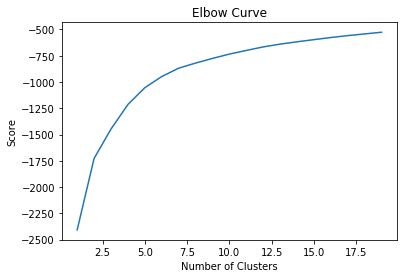

In [220]:
plt.plot(N,score)

plt.xlabel('Number of Clusters')

plt.ylabel('Score')

plt.title('Elbow Curve')

plt.show()